In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def arc_make_input(impurity, f_ash, f_LH, f_DT, print_statements = True):
    
    # Geometry parameters
    
    Rmaj  = 4.8   # Major radius in meters
    a     = 1.35  # Minor radius in meters
    delta = 0.6   # Triangularity
    kappa = 1.8  # Elongation

    # Plasma parameters
    
    B0    = 10.511  # Magnetic field at plasma axis in Tesla
    Ip    = 17.5  # Plasma current in Mega-Amperes

    # Fusion performance parameters
    greenwald_density = Ip / (np.pi * a**2)
    density_to_evaluate_at = greenwald_density
    fgr = density_to_evaluate_at / greenwald_density       #n20     = fgr * n_Gr
    #fgr   = 0.8   # Greenwald fraction
    P_ext = 0.0  # External heating power in Mega-Watts
    
    # Density, temperature
    T0     = 20   
    n_T    = 1.75 
    n_dens = 1.5
    
    # Scaling
    H89 = 1.15
    
    if print_statements: 
        print("--------------------------------------------------------------------")
        print("                      USER INPUTS                    ")
        print("--------------------------------------------------------------------")
        print("PARAMETER              NAME      UNITS          VALUE")  
        print("--------------------------------------------------------------------")
        print("Major Radius            Rmaj       [m]         ", Rmaj)
        print("Minor Radius            a          [m]         ", a)
        print("Triangularity           delta                  ", delta)
        print("Elongation              kappa                  ", kappa)
        print("Field on-axis           B0         [T]         ", B0)
        print("Plasma current          Ip         [MA]        ", Ip)
        print("Greenwald fraction      fgr                    ", fgr)
        print("Input aux. heating      P_ext      [MW]        ", P_ext)
        print("Peak temperature        T0         [keV]       ", T0)
        print("Temperature exponent    n_T                    ", n_T)
        print("Density exponent        n_dens                 ", n_dens)
        print("Impurity                impurity               ", impurity)
        print("Default impurity fraction                      ", 0.001)
        print("He ash fraction         f_ash                  ", f_ash)
        print("P_LH fraction           f_LH                   ", f_LH)
        print("D:T ratio               f_DT                   ", f_DT)
        print("Scaling law             H89                    ", H89)
        print("")
        
    return Rmaj, a, delta, kappa, B0, Ip, fgr, P_ext, T0, n_T, n_dens, impurity, f_ash, f_LH, f_DT, H89

In [3]:
def arc_calc_geom(inputs, print_statements):
    
    Rmaj    = inputs[0]
    a       = inputs[1] 
    delta   = inputs[2]
    kappa   = inputs[3] 
    B0      = inputs[4] 
    Ip      = inputs[5] 
    fgr     = inputs[6]
    P_ext   = inputs[7]
    T0      = inputs[8]
    n_T     = inputs[9] 
    n_dens  = inputs[10]
    impurity = inputs[11]
    f_ash   = inputs[12]
    f_LH    = inputs[13]
    f_DT    = inputs[14]
    H89     = inputs[15]
    
    
    # Calculate geometry and operating conditions based on inputs from arc_make_input

    epsilon = a / Rmaj                                                                 # Inverse aspect ratio
    surf    = (2 * np.pi * Rmaj) * (2 * np.pi * a) * np.sqrt((1 + kappa**2) / 2)       # Plasma surface area in m^2
    vol     = (2 * np.pi * Rmaj) * kappa * (np.pi * a**2)                              # Plasma volume in m^3
    
    rho     = (np.arange(1000) + 1.0) * 0.001                                          # Normalized radius
    r       = rho * a                                                                  # Radial position in m
    dvol    = (2 * np.pi * Rmaj) * kappa * (2 * np.pi * r * (r[1] - r[0]))             # Differential volume in m^3
    dsurf   = (2 * np.pi * Rmaj) * (2 * np.pi * r) * np.sqrt((1 + kappa**2) / 2)       # Differential surface area

    qstar   = 5 * (1 + kappa** 2) * (B0 / Rmaj) * (a**2 /(2*Ip))                       # Effective safety factor 
    n_Gr    = Ip / (np.pi * a**2)                                                      # Greenwald density in n20
    n20     = fgr * n_Gr                                                               # Operating line-averaged density in n20 m^-3
    P_LH    = 0.0488*n20**0.717*B0**0.803*surf**0.941                                  # L-H power threshold in MW                            
    
    
    if print_statements: 
        print("--------------------------------------------------------------------")
        print("                   REACTOR GEOMETRY                 ")
        print("--------------------------------------------------------------------")
        print("PARAMETER              NAME      UNITS         VALUE")  
        print("--------------------------------------------------------------------")
        print("Inverse aspect ratio    epsilon                ", epsilon)
        print("Surface area            surf       [m^2]       ", surf)
        print("Volume                  vol        [m^3]       ", vol)
        print("Effective safety fact.  qstar                  ", qstar)
        print("Greenwald density       n_Gr       [1E20 m^-3] ", n_Gr)
        print("Line-avg density        n20        [1E20 m^-3] ", n20)
        print("L-H power threshold     P_LH       [MW]        ", P_LH)
        print("")
 
    return epsilon, surf, vol, rho, r, dvol, dsurf, qstar,n_Gr, n20, P_LH    


In [4]:
def dt_rate_coeff_bh(Ti):
    
    # Calculates the DT fusion rate coefficient in m^3/s for temperature ti (in keV) based on the Bosch-Hale rates
    
    Bg = 34.3827                 # keV^1/2
    mu_c2 = 1124656.0
    
    C1 = 1.17302e-15             # m^3/s
    C2 = 1.51361e-2
    C3 = 7.51886e-2
    C4 = 4.60643e-3
    C5 = 1.35e-2
    C6 = -1.06750e-4
    C7 = 1.366e-5
    
    # Calculate theta
    theta = Ti / (1.0 - Ti * (C2 + Ti * (C4 + Ti * C6)) / (1.0 + Ti * (C3 + Ti * (C5 + Ti * C7))))
    
    # Calculate psi
    psi = (Bg ** 2 / (4.0 * theta)) ** (1. / 3.)
    
    # Calculate the fusion rate coefficient
    SDT = C1 * theta * np.sqrt(psi / (mu_c2 * Ti ** 3.0)) * np.exp(-3.0 * psi)
    
    return SDT


In [5]:
def get_noble_lrad(T_r, impurity):
    
    # Check if all temperatures are in the valid range
    z = np.where((T_r < 0.1) | (T_r > 100))
    if len(z[0]) > 0:
        print('Bad T out of range!!!')
        return 0

    lrad  = np.zeros(len(T_r))  # For every temperature, calculate lrad and z_avg
    z_avg = np.zeros(len(T_r))
    
    if 'Kr' in impurity:
        t_range = np.array([[0.1, 0.447], [0.447, 2.364], [2.364, 100]])
        a       = np.array([[-3.4512E+01, -2.1484E+01, -4.4723E+01, -4.0133E+01, -1.3564E+01],
                            [-3.1399E+01, -5.0091E-01, 1.9148E+00, -2.5865E+00, -5.2704E+00],
                            [-2.9954E+01, -6.3683E+00, 6.6831E+00, -2.9674E+00, 4.8356E-01]])
        
        z_range = np.array([[0.1, 0.447], [0.447, 4.117], [4.117, 100]])
        b       = np.array([[7.7040E+01, 3.0638E+02, 5.6890E+02, 4.6320E+02, 1.3630E+02],
                            [2.4728E+01, 1.5186E+00, 1.5744E+01, 6.8446E+01, -1.0279E+02],
                            [2.5368E+01, 2.3443E+01, -2.5703E+01, 1.3215E+01, -2.4682E+00]])
        
    elif 'Ar' in impurity: 
        t_range = np.array([[0.1, 0.6], [0.6, 3], [3, 100]])
        a       = np.array([[-3.2155E+01, 6.5221E+00, 3.0769E+01, 3.9161E+01, 1.5353E+01],
                            [-3.2530E+01, 5.4490E-01, 1.5389E+00, -7.6887E+00, 4.9806E+00],
                            [-3.1853E+01, -1.6674E+00, 6.1339E-01, 1.7480E-01, -8.2260E-02]])
        
        z_range = np.array([[0.1, 0.6], [0.6, 3], [3, 100]])
        b       = np.array([[1.3171E+01, -2.0781E+01, -4.3776E+01, -1.1595E+01, 6.8717E+00],
                            [1.5986E+01, 1.1413E+00, 2.5023E+00, 1.8455E+00, -4.8830E-02],
                            [1.4948E+01, 7.9986E+00, -8.0048E+00, 3.5667E+00, -5.9213E-01]])     
        
    elif 'Xe' in impurity: 
        t_range = np.array([[0.1, 0.5], [0.5, 2.5], [2.5, 10], [10, 100]])
        a       = np.array([[-2.9303E+01, 1.4351E+01, 4.7081E+01, 5.9580E+01, 2.5615E+01],
                            [-3.1113E+01, 5.9339E-01, 1.2808E+00, -1.1628E+01, 1.0748E+01],
                            [-2.5813E+01, -2.7526E+01, 4.8614E+01, -3.6885E+01, 1.0069E+01],
                            [-2.2138E+01, -2.2592E+01, 1.9619E+01, -7.5181E+00, 1.0858E+00]])
        
        z_range = np.array([[0.1, 0.3], [0.3, 1.5], [1.5, 8], [8, 100]])
        b       = np.array([[3.0532E+02, 1.3973E+03, 2.5189E+03, 1.9967E+03, 5.8178E+02],
                            [3.2616E+01, 1.6271E+01, -4.8384E+01, -2.9061E+01, 8.6824E+01],
                            [4.8066E+01, -1.7259E+02, 6.6739E+02, -9.0008E+02, 4.0756E+02],
                            [-5.7527E+01, 2.4056E+02, -1.9931E+02, 7.3261E+01, -1.0019E+01]]) 

    for i in range(0, len(t_range)):                                                    # For each pair of points in t_range
        T_r_indicies = np.where((T_r >= t_range[i, 0]) & (T_r <= t_range[i, 1]))[0]        # Find the range of Ti that are between the t range values
        if len(T_r_indicies) > 0 :                                                       # If there's more than one Ti in the current t range values
            coefficients_wrong_order = a[i,:]
            coefficients_correct_order = coefficients_wrong_order[::-1]
            lrad[T_r_indicies] = np.polyval(coefficients_correct_order, np.log10(T_r[T_r_indicies]))           # Construct polynomial out of the "a" coefficients, and evaluate for the given Ti

            
        Z_indicies  = np.where((T_r >= z_range[i, 0]) & (T_r <= z_range[i, 1]))[0]        # Find the range of Ti that are between the z range values 
        if len(Z_indicies) > 0 :                                                        # If there's more than one Ti in the current z range values
            coefficients_wrong_order = b[i,:]
            coefficients_correct_order = coefficients_wrong_order[::-1]
            z_avg[Z_indicies] = np.polyval(coefficients_correct_order, np.log10(T_r[Z_indicies]))            # Construct polynomial out of the "b" coefficients and evaluate for the given Ti
            
    lrad = 10**lrad

    return lrad, z_avg


In [6]:
def arc_calc_core_lmode(inputs, geometry, print_statments):
    
    Rmaj    = inputs[0]
    a       = inputs[1] 
    delta   = inputs[2]
    kappa   = inputs[3] 
    B0      = inputs[4] 
    Ip      = inputs[5] 
    fgr     = inputs[6]
    P_ext   = inputs[7]
    T0      = inputs[8]
    n_T     = inputs[9] 
    n_dens  = inputs[10]
    impurity = inputs[11]
    f_ash   = inputs[12]
    f_LH    = inputs[13]
    f_DT    = inputs[14]
    H89     = inputs[15]
    
    epsilon = geometry[0]
    surf    = geometry[1]
    vol     = geometry[2]
    rho     = geometry[3]
    r       = geometry[4]
    dvol    = geometry[5]
    dsurf   = geometry[6]
    qstar   = geometry[7]
    n_Gr    = geometry[8]
    n20     = geometry[9]
    P_LH    = geometry[10]
    
    # Calculates power and equilibrium conditions for the ARC core with parameters from a=arc_calc_geom
    # for an L-mode temperature profile T0(1-rho^2)^n_T, so no pedestal
    
    # Density profile
    n20_r_shape = (0.6 * ((1 - rho**2)**n_dens)) + 0.4
    n20_r       = n20 * (n20_r_shape / np.mean(n20_r_shape))
    n20_avg     = np.sum(n20_r * dvol) / np.sum(dvol)
    
    n_peaking   = n20_r[0] #/ n20_avg
    
    # Temperature profile
    T_r         = ((T0 - 0.1) * ((1 - rho**2)**n_T)) + 0.1
    T_avg       = np.sum(T_r * dvol) / np.sum(dvol)
    
    # Standard parameters
    p_r         = 2 * (n20_r * 1e20) * (T_r * 1e3) * 1.6e-19 / 1e6          # Pressure profile in MPa
    p_avg       = np.sum(p_r * dvol) / np.sum(dvol)                         # Volume-averaged pressure in MPa
    beta_t      = 100 * p_avg / (0.3979 * B0**2)                            # Toroidal beta
    beta_n      = beta_t / (Ip / (a * B0))                                  # Normalized beta
    Wth         = np.sum(1.5 * p_r * dvol)                                  # Stored thermal energy in MJ
    T_avg_Wth   = (p_avg * 1e6) / (2.0 * (n20 * 1e20) * 1.6e-19 * 1000)     # Averaged temperature from <p> and line average density
    Coulomb_log = np.log(4.9e7 * T_r**1.5 / np.sqrt(n20_r))                 # Coulomb log profile
    sigmas_r    = (T_r**1.5) / (Coulomb_log * 1.65e-9)                      # Plasma conductivity in S/m radial profile
    sigmas_avg  = np.sum(sigmas_r * dvol) / np.sum(dvol)                    # Surface-averaged conductivity in S/m
    Seff        = sigmas_avg * kappa * (np.pi * a**2) / (2 * np.pi * Rmaj)  # Effective conductance Sievert
    Reff        = 1 / Seff                                                  # Effective plasma resistance, ohm
    Pohm        = Reff * (Ip**2) * 1e6                                      # Ohmic heating in MW
    Vloop       = Reff *  Ip     * 1e6                                      # Loop voltage in V
    
    # Fusion power using DT rate coefficient, assuming pure D-T
    SDT_r       = dt_rate_coeff_bh(T_r)                                     # Rate coefficient radial profile in m3/s
    pfus_r      = (1/4) * (n20_r * 1e20)**2 * SDT_r * 1.6e-19 * 17.6        # P_fusion in MW/m3
    Pfus        = np.sum(pfus_r * dvol)                                     # Total fusion power in MW
    Palpha      = (1/5) * Pfus                                              # Alpha power in MW
    
    # Calculate radiated power and average Z of the seeded impurity required for keeping the plasma in L-mode and/or power exhaust
    # For simplicity, this assumes the impurity fraction is 1e-3
    
    if 'Kr' in impurity:
        lrad, z_avg = get_noble_lrad(T_r, 'Kr')
    
    elif 'Ar' in impurity:
        lrad, z_avg = get_noble_lrad(T_r, 'Ar')
    
    elif 'Xe' in impurity: 
        lrad, z_avg = get_noble_lrad(T_r, 'Xe') 
        
    elif 'pure' in impurity:
        lrad, z_avg = np.nan, np.nan
        
    else:
        raise ValueError("Unknown impurity type")
    
    prad        = np.sum( (((n20_r * 1e20)**2 * lrad) / (1e6 * 1000)) * dvol)
    zdilute     = np.sum(z_avg * pfus_r * dvol) / np.sum(pfus_r * dvol)
    print('zdilute: {}'.format(zdilute))
    print('mean(z_avg) = {}'.format(np.mean(z_avg)))

    if print_statements: 
        print("--------------------------------------------------------------------")
        print("                   CORE PARAMETERS                  ")
        print("--------------------------------------------------------------------")
        print("PARAMETER              NAME      UNITS         VALUE")  
        print("--------------------------------------------------------------------")
        print("Vol. avg. density       n20_avg    [1E20 m^-3] ", n20_avg)
        print("Peak density            n_peaking  [1E20 m^-3] ", n_peaking)
        print("Vol. avg. temperature   T_avg      [keV]       ", T_avg)
        print("Peak temperature        T0         [keV]       ", T0)
        print("Power avg. temperature  T_avg_Wth  [keV]       ", T_avg_Wth)
        print("Vol. avg. power         p_avg      [MW]        ", p_avg)
        print("Toroidal beta           beta_t                 ", beta_t)
        print("Norm. toroidal beta     beta_n                 ", beta_n)
        print("Stored thermal energy   Wth        [MJ]        ", Wth)
        print("Fusion power  (D:T=1)   Pfus       [MW]        ", Pfus)
        print("Alpha heating (D:T=1)   Palpha     [MW]        ", Palpha)
        print("Plasma resistance       Reff       [ohms]      ", Reff)
        print("Ohmic heating           Pohm       [MW]        ", Pohm)
        print("Loop voltage            Vloop      [V]         ", Vloop)
        print("Radiated power          prad       [MW]        ", prad)
        print("Pfus weighted over Z    zdilute                ", zdilute)
        print("")

    return n20_avg, n_peaking, T_avg, T_avg_Wth, p_avg, beta_t, beta_n, Wth, Pfus, Palpha, Reff, Pohm, Vloop, sigmas_r, n20_r, T_r, lrad, z_avg, prad, zdilute
    

In [7]:
def arc_solve_lmode(inputs, geometry, core, print_statements):
    
    Rmaj    = inputs[0]
    a       = inputs[1] 
    delta   = inputs[2]
    kappa   = inputs[3] 
    B0      = inputs[4] 
    Ip      = inputs[5] 
    fgr     = inputs[6]
    P_ext   = inputs[7]
    T0      = inputs[8]
    n_T     = inputs[9] 
    n_dens  = inputs[10]
    impurity = inputs[11]
    f_ash   = inputs[12]
    f_LH    = inputs[13]
    f_DT    = inputs[14]
    H89     = inputs[15]
    
    epsilon = geometry[0]
    surf    = geometry[1]
    vol     = geometry[2]
    rho     = geometry[3]
    r       = geometry[4]
    dvol    = geometry[5]
    dsurf   = geometry[6]
    qstar   = geometry[7]
    n_Gr    = geometry[8]
    n20     = geometry[9]
    P_LH    = geometry[10]
    
    n20_avg   = core[0]
    n_peaking = core[1]
    T_avg     = core[2]
    T_avg_Wth = core[3]
    p_avg     = core[4]
    beta_t    = core[5]
    beta_n    = core[6]
    Wth       = core[7]
    Pfus      = core[8]
    Palpha    = core[9]
    Reff      = core[10]
    Pohm      = core[11]
    Vloop     = core[12]
    sigmas_r  = core[13]
    n20_r     = core[14]
    T_r       = core[15]
    lrad      = core[16]
    z_avg     = core[17]
    prad      = core[18]
    zdilute   = core[19]
    
    pfus_scalar        = f_DT * (2.0 - f_DT)                                                                                            # Scalar factor that will be applied to correct alpha power if necessary
    H89_scaling_string = np.sqrt(2.5) * 0.048 * H89 * (n20**0.1) * (Ip**0.85) * (Rmaj**1.2) * (a**0.3) * (kappa**0.5) * (B0**0.2)       # Uses line-averaged density; units of this string are MJ^-0.5 s^-0.5, apparently this is a definition
    Ploss              = (Wth / H89_scaling_string)**2                                                                                  # Ploss over entire plasma 
    tau_E              = Wth / Ploss                                                                                                    # Energy confinement time
    
    if 'pure' in impurity: 
        Prad      = 0                                                                                         # Radiated power in MW
        f_imp     = 0                                                                                         # NEW Impurity fraction
        Palpha    = pfus_scalar * ((1 - 2*f_ash)**2) * Palpha                                                 # NEW Palpha accounting for possibility of D:T =/= 1 AND He ash 
        Pfus      = 5 * Palpha                                                                                # NEW Pfus accounting for possibility of D:T =/= 1 AND He ash
        Pext      = Ploss - Palpha                                                                            # Pext required for steady state (equillibrium) operation (i.e. the Pext traditionally solved for by popcon)
        Qp        = Pfus / Pext                                                                               # Plasma Q 
        palpha    = 3.5 * (1/4) * ((n20_r*1e20)**2) * ((1 - 2*f_ash)**2) * dt_rate_coeff_bh(T_r) * (1.6e-19)  # Alpha heating radial profile! As a function of r
        prad      = np.zeros(len(T_r))                                                                        # Radiative power loss radial profile! As a function of r
        
    elif 'Kr' or 'Ar' or 'Xe' in impurity: 
        Prad      = Ploss - (f_LH*P_LH)                                                                                           # Ploss - Prad_new = f_LH*P_LH
        f_imp     = (1/1000) * (Prad / prad)                                                                                      # Original f_imp was 1/1000; original prad was prad
        Palpha    = pfus_scalar * ((1 - 2*f_ash - zdilute*f_imp)**2) * Palpha                                                    # NEW Pfus accounting for possibility of D:T =/= 1 AND He ash AND noble gas impurities
        print('dilution_factor={}'.format(((1 - 2*f_ash - zdilute*f_imp)**2)))
        Pfus      = 5 * Palpha                                                                                                    # NEW Pfus accounting for possibility of D:T =/= 1  AND He ash AND noble gas impurities
        Pext      = Ploss - Palpha                                                                                                # Pext required for steady state (equillibrium) operation (i.e. the Pext traditionally solved for by popcon)
        Qp        = Pfus / Pext                                                                                                   # Plasma Q 
        palpha    = 3.5 * (1/4) * ((n20_r*1e20)**2) * ((1 - 2*f_ash - zdilute*f_imp)**2) * dt_rate_coeff_bh(T_r) * (1.6e-19)      # Alpha heating radial profile! As a function of r
        prad      = (f_imp * ((n20_r*1e20)**2) * lrad) / 1e6                                                                      # Radiative power loss radial profile! As a function of r
    
    Pnet = np.zeros(len(T_r))
    Pnet[0] = (palpha[0] + (Pext / vol) - prad[0]) * dvol[0]                                                                      # First term in net power
    for i in range(1, len(T_r)):
        Pnet[i] = Pnet[i-1] + (palpha[i] + (Pext / vol) - prad[i]) * dvol[i]

    qloss = Pnet / dsurf                                                                                                          # Conducted areal power density [MW/m^2]
    dTdr  = 1000 * np.gradient(T_r, r)                                                                                            # dT/dr in eV/m
    chi   = (-1 * (qloss*1e6)) / ((1.6e-19)*(n20_r*1e20)*dTdr)                                                                    # Effective heat diffusivity [m^2 / s]
    Psol  = Ploss - Prad                                                                                                          # Power to scrape off layer
    
    if print_statements: 
        print("--------------------------------------------------------------------")
        print("                   CORE POWERS                 ")
        print("--------------------------------------------------------------------")
        print("PARAMETER              NAME      UNITS         VALUE")  
        print("--------------------------------------------------------------------")
        print("D:T scalar correction   pfus_scalar            ", pfus_scalar)
        print("Total power loss        Ploss      [MW]        ", Ploss)
        print("Confinement time        tau_E      [s]         ", tau_E)
        print("Total radiated power    Prad       [MW]        ", Prad)
        print("Impurity fraction req.  f_imp                  ", f_imp)
        print("Helium ash fraction     f_ash                  ", f_ash)
        print("He ash impurity factor  (1 - 2*f_ash)**2       ", (1 - 2*f_ash)**2)
        print("Total alpha heating     Palpha     [MW]        ", Palpha)
        print("Total fusion power      Pfus       [MW]        ", Pfus)
        print("Equi. external heating  Pext       [MW]        ", Pext)
        print("Total SOL power         Psol       [MW]        ", Psol)
        print("Plasma Q                Qp                     ", Qp)
        print("")   

    return Prad, Ploss, Palpha, Pfus, Psol, tau_E, Pext, Qp, palpha, prad, Pnet, qloss, chi


In [8]:
def arc_calc_popcon_lmode(T0_range, impurity, f_ash, f_LH, f_DT, print_statements):
    
    T_0  = np.arange((T0_range[1] - T0_range[0]) / 0.25 + 1) * 0.25 + T0_range[0]
    fgreen = np.arange(len(T_0)) * 0.015 + 0.05

    pfus = np.zeros((len(T_0), len(fgreen)))
    pext = np.zeros((len(T_0), len(fgreen)))
    prad = np.zeros((len(T_0), len(fgreen)))
    psol = np.zeros((len(T_0), len(fgreen)))
    qpar = np.zeros((len(T_0), len(fgreen)))
    Qp   = np.zeros((len(T_0), len(fgreen)))
    
    inputs  = list(arc_make_input(impurity, f_ash, f_LH, f_DT, print_statements))
    Rmaj    = inputs[0]
    a       = inputs[1] 
    delta   = inputs[2]
    kappa   = inputs[3] 
    B0      = inputs[4] 
    Ip      = inputs[5] 
   
    P_ext   = inputs[7]
    
    n_T     = inputs[9] 
    n_dens  = inputs[10]
    impurity = inputs[11]
    f_ash   = inputs[12]
    f_LH    = inputs[13]
    f_DT    = inputs[14]
    H89     = inputs[15]
    
    for i in range(0, len(T_0)):

        inputs[8] = T_0[i]
        
        for j in range(0, len(fgreen)):
            
            inputs[6] = fgreen[j]   # Greenwald
    
            geometry = arc_calc_geom(inputs, print_statements)
            core     = arc_calc_core_lmode(inputs, geometry, print_statements)
            powers   = arc_solve_lmode(inputs, geometry, core, print_statements)
            
            pfus[i, j] = powers[3]    
            pext[i, j] = powers[6]      
            prad[i, j] = powers[0]    
            psol[i, j] = powers[4]     
            
            Bpol    = (0.2 * Ip) / (a * np.sqrt(0.5 * (1 + kappa**2)))
            lambdaq = 3 * 6.3e-4 / Bpol**1.19
            Asol    = 4 * np.pi * Rmaj * lambdaq * Bpol / B0
            
            qpar[i,j] = psol[i, j] / Asol
            Qp[i, j]  = powers[7] 
            if Qp[i, j] < 0.0:
                Qp[i, j] = 1000.0
            if Qp[i, j] > 1000.0:
                Qp[i, j] = 1000.0

    return T_0, fgreen, pfus, pext, Qp, prad, psol, qpar



In [9]:
def contour_arc_lmode(popcon, plot_id=None):
    
    """Plotting function"""

    T_0     = popcon[0]
    fgreen  = popcon[1]
    pfus    = popcon[2]
    pext    = popcon[3]
    Qp      = popcon[4]
    prad    = popcon[5]
    psol    = popcon[6]
    qpar    = popcon[7]
    
    col = plt.get_cmap('tab10').colors

    if plot_id is None:
        plot_id = 1

    if plot_id == 1:  # Fusion power and external power
        pfus_level = [20, 30, 50, 100, 200, 300, 500, 1000, 2000, 3000, 4000]
        cs_pfus = plt.contour(T_0, fgreen, np.rot90(np.flipud(pfus), k=-1), levels=pfus_level, colors='black')
    
        pext_level = [-20, -10, -5, -2.5, 0, 2.5, 5, 10, 20, 25, 50]
        cs_pext = plt.contour(T_0, fgreen, np.rot90(np.flipud(pext), k=-1), levels=pext_level, colors='red')
        
        #Qp_level = [1, 2, 3, 5, 10, 20, 30, 50, 100, 1000]
        #cs_Qp = plt.contour(T_0, fgreen, np.rot90(np.flipud(Qp), k=-1), levels=Qp_level, colors='green')

        # Plot contour level numbers
        plt.clabel(cs_pfus, fmt='%d', colors='black', fontsize=10)
        plt.clabel(cs_pext, fmt='%d', colors='red', fontsize=10)
        #plt.clabel(cs_Qp, fmt='%d', colors='green', fontsize=10)

        plt.xlabel('T0 (keV)')
        plt.ylabel('f_Gr')
        plt.title('P in MW (fusion:black) (ext:red) (Qp:green)')

    #elif plot_id == 3:  # Prad/S
    #    prad_surf_level = [0.1, 0.3, 0.5, 1, 2, 3, 4, 5]
    #    plt.contour(T_0, fgreen, prad / surf, levels=prad_surf_level)
        
    #    plt.xlabel('T0 (keV)')
    #    plt.ylabel('f_Gr : n20_Gr=' + '{:.2f}'.format(f['a']['n_gr']))
    #    plt.title('Prad/S (MW/m2)')

    elif plot_id == 4:  # q_par
        qpar_level = [100, 200, 400, 700, 1000, 2000, 4000, 7000, 10000, 20000, 40000]
        plt.contour(T_0, fgreen, qpar, levels=qpar_level)
        
        plt.xlabel('T0 (keV)')
        plt.ylabel('f_Gr : n20_Gr=')
        plt.title('q// (MW/m2)')

    else:
        print('Invalid plot id')

    plt.show()

    return 0

In [10]:
def leg1():
    return

zdilute: 26.682545555453014
mean(z_avg) = 23.68511311352451
dilution_factor=1.4502334186164871
zdilute: 26.682545555453014
mean(z_avg) = 23.68511311352451
dilution_factor=1.312941058469668
zdilute: 26.682545555453014
mean(z_avg) = 23.68511311352451
dilution_factor=1.2358731185553928
zdilute: 26.682545555453014
mean(z_avg) = 23.68511311352451
dilution_factor=1.1871647424276395
zdilute: 26.68254555545301
mean(z_avg) = 23.68511311352451
dilution_factor=1.1538869911975833
zdilute: 26.682545555453018
mean(z_avg) = 23.68511311352451
dilution_factor=1.1298629320692462
zdilute: 26.682545555453014
mean(z_avg) = 23.68511311352451
dilution_factor=1.1117914986586543
zdilute: 26.682545555453018
mean(z_avg) = 23.68511311352451
dilution_factor=1.0977578257509688
zdilute: 26.68254555545301
mean(z_avg) = 23.68511311352451
dilution_factor=1.0865792606962261
zdilute: 26.682545555453018
mean(z_avg) = 23.68511311352451
dilution_factor=1.0774882433290944
zdilute: 26.682545555453014
mean(z_avg) = 23.68511311

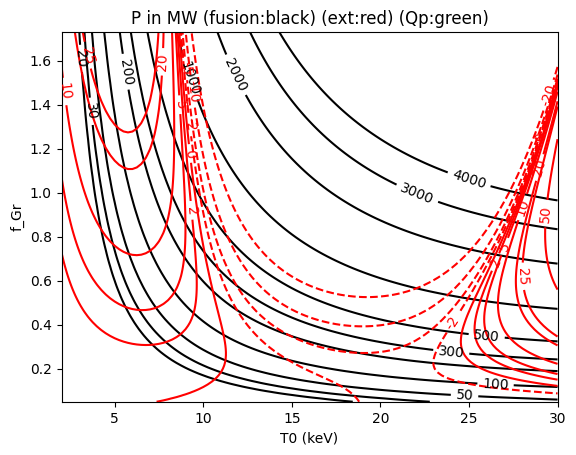

0

In [11]:
print_statements     = False
impurity             = 'Kr'
f_ash                = 0
f_LH                 = 1.13
f_DT                 = 1

T0_range             = [2, 30]

popcon   = arc_calc_popcon_lmode(T0_range, impurity, f_ash, f_LH, f_DT, print_statements)

contour_arc_lmode(popcon, plot_id=None)


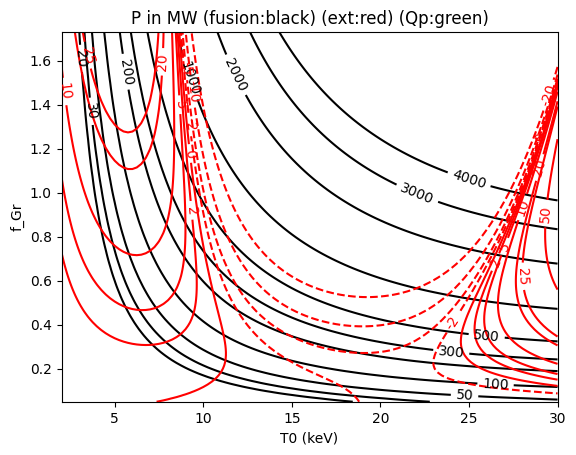

0

In [12]:
contour_arc_lmode(popcon, plot_id=None)

In [15]:
print_statements     = True
impurity             = 'Kr'
f_ash                = 0.02
f_LH                 = 1.00
f_DT                 = 1

inputs   = arc_make_input(impurity, f_ash, f_LH, f_DT, print_statements)
geometry = arc_calc_geom(inputs, print_statements)
core     = arc_calc_core_lmode(inputs, geometry, print_statements)
powers   = arc_solve_lmode(inputs, geometry, core, print_statements)

--------------------------------------------------------------------
                      USER INPUTS                    
--------------------------------------------------------------------
PARAMETER              NAME      UNITS          VALUE
--------------------------------------------------------------------
Major Radius            Rmaj       [m]          4.8
Minor Radius            a          [m]          1.35
Triangularity           delta                   0.6
Elongation              kappa                   1.8
Field on-axis           B0         [T]          10.511
Plasma current          Ip         [MA]         17.5
Greenwald fraction      fgr                     1.0
Input aux. heating      P_ext      [MW]         0.0
Peak temperature        T0         [keV]        20
Temperature exponent    n_T                     1.75
Density exponent        n_dens                  1.5
Impurity                impurity                Kr
Default impurity fraction                       0.001
He 

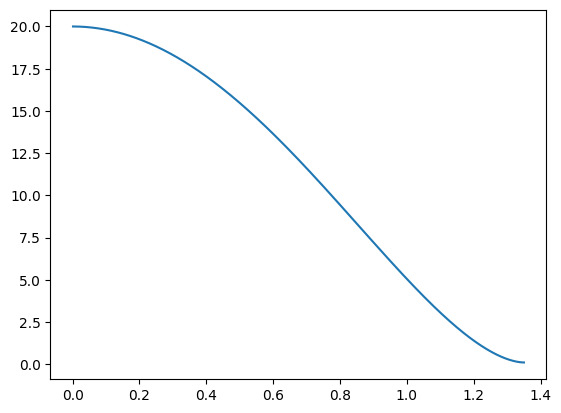

In [14]:
Rmaj    = inputs[0]
a       = inputs[1] 
delta   = inputs[2]
kappa   = inputs[3] 
B0      = inputs[4] 
Ip      = inputs[5] 
fgr     = inputs[6]
P_ext   = inputs[7]
T0      = inputs[8]
n_T     = inputs[9] 
n_dens  = inputs[10]
impurity = inputs[11]
f_ash   = inputs[12]
f_LH    = inputs[13]
f_DT    = inputs[14]
H89     = inputs[15]
    
epsilon = geometry[0]
surf    = geometry[1]
vol     = geometry[2]
rho     = geometry[3]
r       = geometry[4]
dvol    = geometry[5]
dsurf   = geometry[6]
qstar   = geometry[7]
n_Gr    = geometry[8]
n20     = geometry[9]
P_LH    = geometry[10]

n20_avg   = core[0]
n_peaking = core[1]
T_avg     = core[2]
T_avg_Wth = core[3]
p_avg     = core[4]
beta_t    = core[5]
beta_n    = core[6]
Wth       = core[7]
Pfus      = core[8]
Palpha    = core[9]
Reff      = core[10]
Pohm      = core[11]
Vloop     = core[12]
sigmas_r  = core[13]
n20_r     = core[14]
T_r       = core[15]
lrad      = core[16]
z_avg     = core[17]
prad      = core[18]
zdilute   = core[19]

plt.plot(r, T_r)